In [16]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [17]:
if IN_COLAB:
    TRIPS_PATH = "/content/drive/MyDrive/Project/"
else:
    TRIPS_PATH = "../data/"
TRIPS_PATH += "NYC_Pilot2_PM_Part1.csv"

if IN_COLAB:
    POLYGON_PATH = "/content/drive/MyDrive/Project/"
else:
    POLYGON_PATH = "../data/"
POLYGON_PATH += "nyc_polygon.geojson"

if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE.csv"

In [18]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [19]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt

import h3

In [20]:
h3_resolution = 9

In [21]:
trips = pd.read_csv(TRIPS_PATH)

In [22]:
trips['h3'] = trips.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis = 1)

In [23]:
from shapely.geometry import Polygon #adding a geometry row, using our h3 column
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['h3'], True)
  return Polygon(points)

In [24]:
reference_value = pd.read_csv(REF_PATH)
reference_value['neighborhood'].nunique()

48

In [25]:
neighborhoods = gpd.read_file(POLYGON_PATH)

In [45]:
def mean_absolute_percentage_error(actual, predicted):
    actual= np.array(actual)
    predicted = np.array(predicted)
    return np.mean(np.abs((actual - predicted) / np.maximum(actual, 0.01))) * 100

In [46]:
def get_mape_h3(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_pm25 = (sampled_trips
                          .groupby('h3')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())# Make a list of pm25 values for each h3 cell

        df_pm25['average_pm25_value'] = df_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each h3 cell
        df_pm25.drop('pm25_list', axis = 1, inplace=True)
        df_pm25['geometry'] = (df_pm25.apply(add_geometry,axis=1)) #adding a geometry row, using our h3 column
        gdf_pm25 = gpd.GeoDataFrame(df_pm25, geometry = df_pm25.geometry) #Convert DataFrame to GeoDataFrame
        gdf_pm25.set_crs('epsg:4326', inplace = True)
        gdf_sampled_trips = gpd.GeoDataFrame(sampled_trips, geometry = gpd.points_from_xy(sampled_trips.longitude, sampled_trips.latitude))
        gdf_sampled_trips.set_crs('epsg:4326', inplace = True)
        sampled_trips_with_neighborhood = gpd.sjoin(gdf_sampled_trips, neighborhoods, predicate='within') #neighborhoods present in our sample
        sampled_trips_with_neighborhood.drop('index_right', axis = 1,inplace=True) #Needs to be dropped for the next sjoin to work
        sjoined_trips_original = gpd.sjoin(sampled_trips_with_neighborhood, gdf_pm25, how='inner').reset_index(drop = True)
        sjoined_trips = sjoined_trips_original[['neighborhood', 'average_pm25_value']]
#If a neighborhood is not present in our sample, but present in the reference DataFrame, then set the pm25 of that neighborhood to 0 in our sample. 
#This is needed to make the length of the two lists equal, to calculate RMSE
        for neighborhds in baseline['neighborhood']:
            if neighborhds not in sjoined_trips['neighborhood']:
                sjoined_trips.loc[len(sjoined_trips.index)] = [neighborhds, 0] 
        baseline_pm25 = baseline['average_pm25_value'].tolist()
        sampled_pm25 = sjoined_trips.groupby('neighborhood')['average_pm25_value'].mean().tolist()

        mape = mean_absolute_percentage_error(sampled_pm25, baseline_pm25) #calculate MAPE
        error.append(mape) #Append to Error list
    return error

In [47]:
MAPE_H3 = get_mape_h3(reference_value,trips)

C:\Users\mohan\AppData\Local\Temp\ipykernel_1152\3694386770.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = encoded.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
C:\Users\mohan\AppData\Local\Temp\ipykernel_1152\3694386770.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sjoined_trips.loc[len(sjoined_trips.index)] = [neighborhds, 0]
C:\Users\mohan\AppData\Local\Temp\ipykernel_1152\3694386770.py:28: SettingWithCopyWarning: 
A v

In [48]:
MAPE_H3

[8802.762845718526,
 5866.0180822501925,
 5865.057861547206,
 6495.64443055464,
 4425.439137344601,
 22.213106016770958,
 1382.4711313437654,
 22.417502807159973,
 22.92182083110517,
 22.10228200709684]

<Figure size 640x480 with 0 Axes>

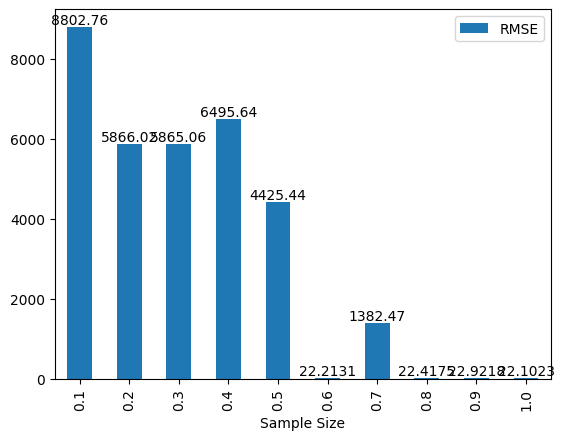

In [49]:
H3_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'RMSE': MAPE_H3})
plt.figure()
ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()